In [1]:
import xarray as xr
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
import xrft
import glob

### Read data 
Either concatenate along time dimension or at one time.

In [4]:
''' Lazy read in multiple time snapshots. '''

# NL = 15
ds1 = xr.open_mfdataset('../../multilayer/JFM2023/compilation/C4/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds1.attrs['t']
ds1 = ds1.chunk({'x':-1, 'y':-1})
ds1 = ds1.sortby('t')

# NL = 30
ds2 = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/Cvalid1/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds2.attrs['t']
ds2 = ds2.chunk({'x':-1, 'y':-1})
ds2 = ds2.sortby('t')

# NL = 45
ds3 = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/Cvalid2/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds3.attrs['t']
ds3 = ds3.chunk({'x':-1, 'y':-1})
ds3 = ds3.sortby('t')

In [2]:
''' Or read in one time. '''
t = 160
ds1 = xr.open_dataset('../../multilayer/JFM2023/compilation/C4/field%g.nc' %t)  
ds2 = xr.open_dataset('../../multilayer/JFM2023/compilation/Cvalid1/field%g.nc' %t)  
ds3 = xr.open_dataset('../../multilayer/JFM2023/compilation/Cvalid2/field%g.nc' %t)  

In [21]:
''' Check the depth that is consistently below water. '''
print(ds1.z.isel(zl=-1).min().values)
print(ds2.z.isel(zl=-1).min().values)
print(ds3.z.isel(zl=-1).min().values)

-1.5710276365280151
-1.5125674158334732
-1.4919191226363182


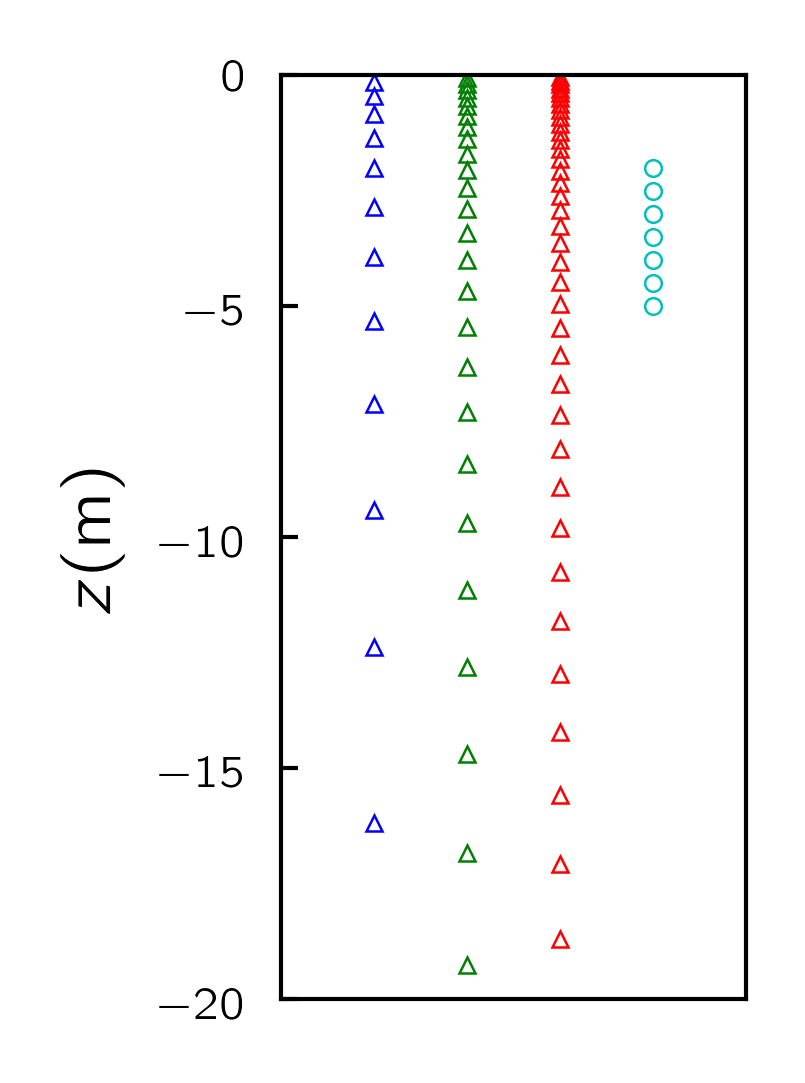

In [25]:
''' Demonstrate layer depth '''
plt.figure(figsize=[1,2]); ax = plt.gca()

depth = - 5 # depth choice
znew = np.arange(-5,-1.5,0.5)

# z1 = ds1.z.mean(dim=['x','y','t'])
# z2 = ds2.z.mean(dim=['x','y','t'])
# z3 = ds3.z.mean(dim=['x','y','t'])

# check a particular depth 
# print('Layer %g at depth choice' %np.abs(z2.values - depth).argmin())

plt.plot(np.ones(ds1.sizes['zl']), z1, '^')
plt.plot(2*np.ones(ds2.sizes['zl']), z2,'^')
plt.plot(3*np.ones(ds3.sizes['zl']), z3,'^')
plt.plot(4*np.ones(len(znew)), znew,'o')
plt.ylim([-20,0]); plt.xlim([0,5])
plt.ylabel('$z \mathrm{ (m)}$')
plt.yticks([-20,-15,-10,-5,0])
ax.get_xaxis().set_visible(False)
plt.savefig('../figures/multilayer-diss/coord.tiff', bbox_inches='tight')

### Interpolate onto regular (evenly spaced) z grid 
Cannot directly use the xarray interp method because z is not an independent dimension. Instead we call the scipy interp1d function iteratively.

In [5]:
from mlpython.utils import interpz

#### Horizontal velocity

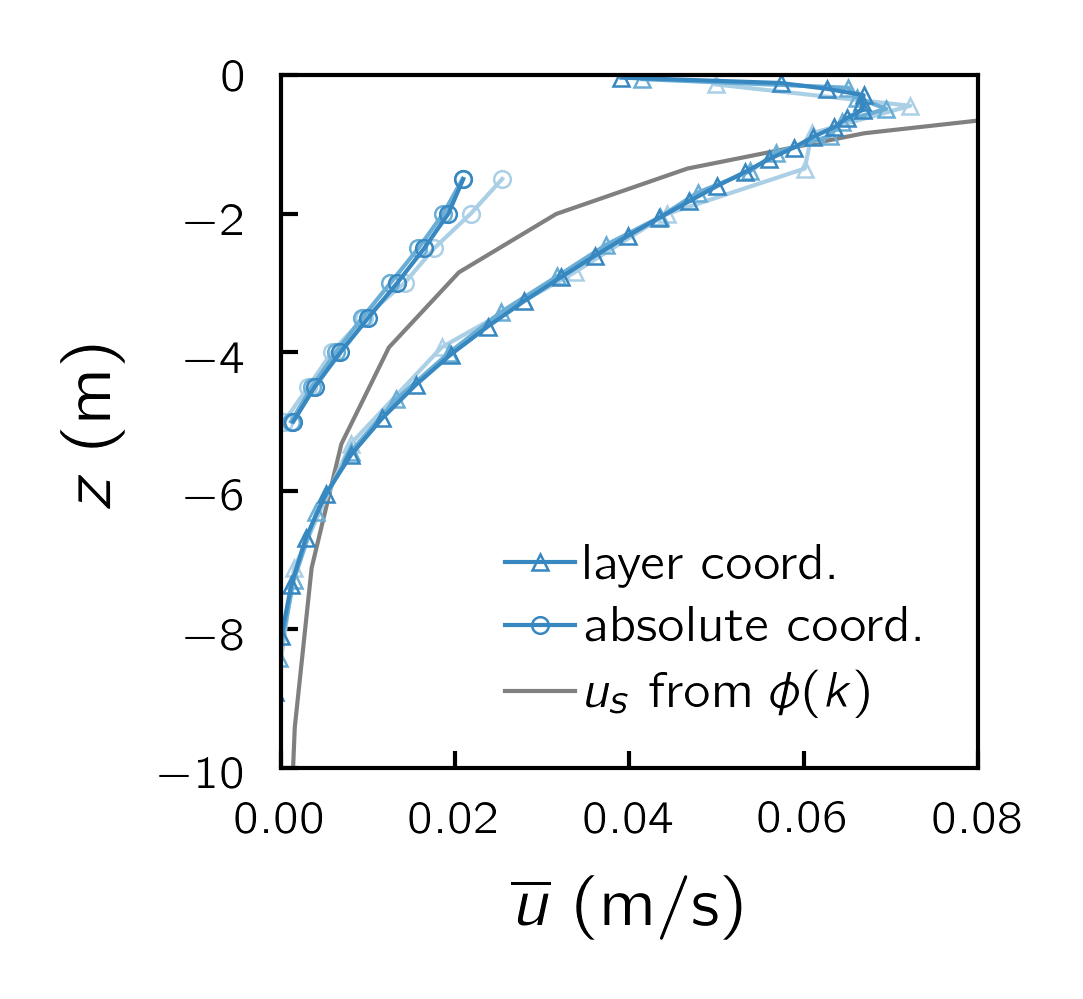

In [8]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# lss = ['-o', '-^', '-s']
colors = ['tab:brown','tab:pink','tab:olive']

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     # layered coordinate
#     var = ds.ux
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

# Plot the corresponding Stokes drift magnitude
from utils import spectrum_us
filename = '../../multilayer/JFM2023/compilation/' + 'dissipation_' + 'C4' + '.nc'
diss = xr.open_dataset(filename, engine='h5netcdf')
zmean = ds1.z.sel(t=t).mean(['x','y'])
us = spectrum_us(diss.kbins, diss.F[-1], zmean.values) # The last time step in the dissipation file (t=160-180)
ls, = ax.plot(us, zmean, c='gray')

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    l1, = ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6))
    l2, = ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
    
        
ax.set_ylim([-10,0])
ax.set_xlim([0,0.08])
# ax.set_xscale('log')
ax.set_xlabel(r'$\overline{u} \; \mathrm{(m/s)}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
# ax.set_ylabel(r'$\overline{z_l} \; \mathrm{or} \; z$', labelpad=0)
plt.legend([l1, l2, ls], ['layer coord.', 'absolute coord.', '$u_s \; \mathrm{from}  \; \phi(k)$'], 
           frameon=False, loc='lower right', fontsize=6)  # Remove legend box
plt.savefig('../figures/multilayer-diss/uaver_new.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
ds

<xarray.Dataset>
Dimensions:  (t: 9, zl: 15, x: 1024, y: 1024)
Coordinates:
  * t        (t) int64 0 40 80 110 120 130 150 160 170
  * x        (x) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
  * y        (y) float64 -99.9 -99.71 -99.51 -99.32 ... 99.32 99.51 99.71 99.9
    z        (t, zl, x, y) float64 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
Dimensions without coordinates: zl
Data variables:
    ux       (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    uy       (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    uz       (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    omegax   (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    omegay   (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    omegaz   (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    dzdx     (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
    dzdy     (t, zl, x, y) float32 dask.array<chunksize=(1, 15, 1024, 1024), meta=np.ndarray>
Attributes:
    caselabel:  C4
    path:       /projects/DEIKE/jiarongw/multilayer/revision/field_new_200m_P...

/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_2397/1793854119.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (


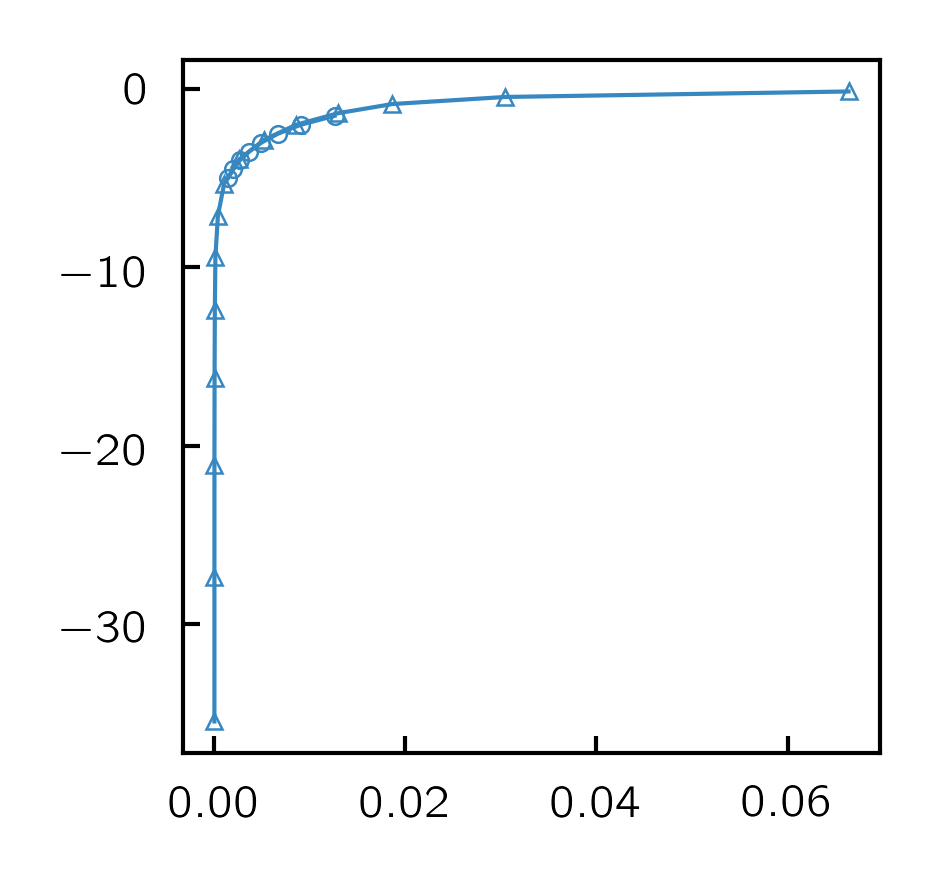

In [12]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# lss = ['-o', '-^', '-s']
colors = ['tab:brown','tab:pink','tab:olive']

ds = ds1

# layered coordinate
var = ds.omegax**2 + ds.omegay**2 + ds.omegaz**2
var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))

zmean = ds.z.sel(t=t).mean(['x','y'])
mean = var.sel(t=t).mean(['x','y'])
mean_interp = var_interp.mean(['x','y'])
l1, = ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6))
l2, = ax.plot(mean_interp, znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))

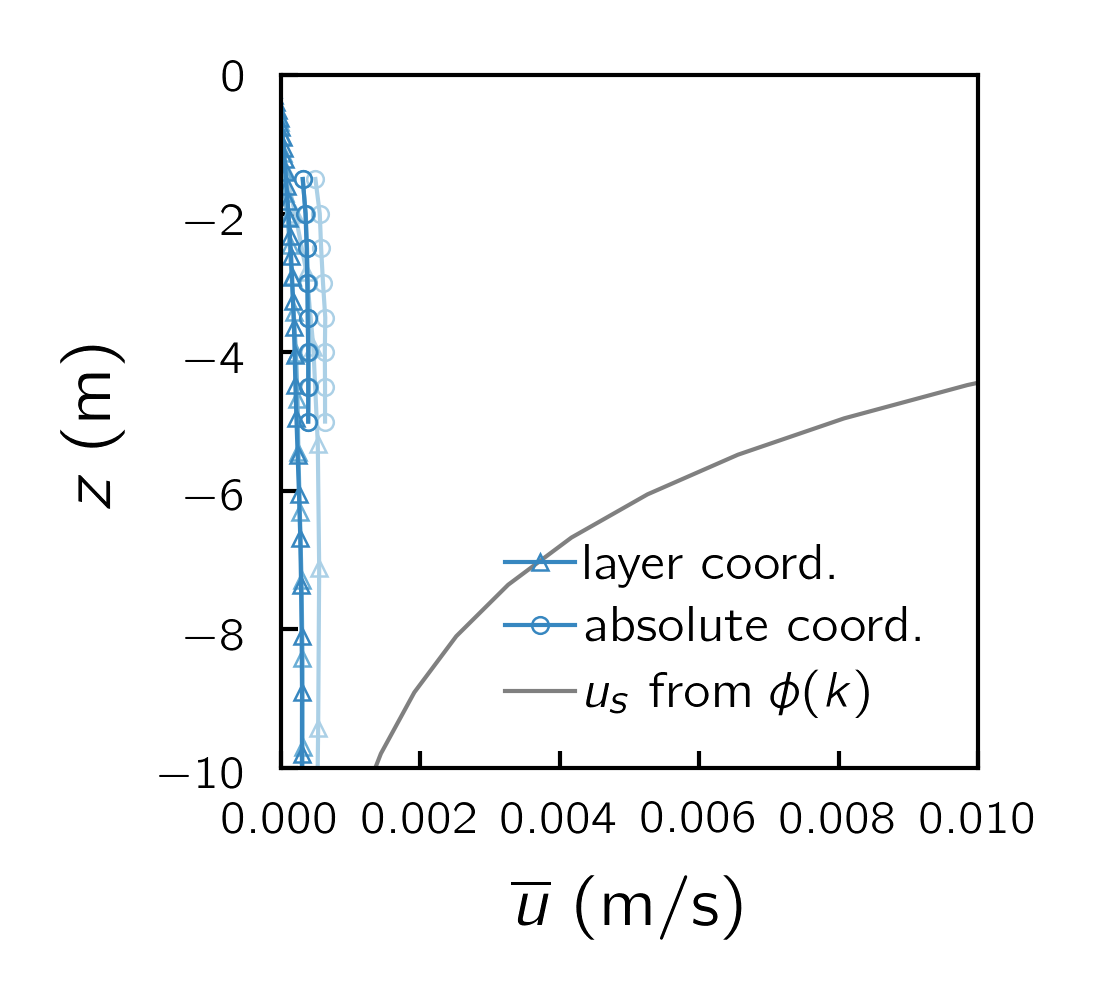

In [9]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# lss = ['-o', '-^', '-s']
colors = ['tab:brown','tab:pink','tab:olive']

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     # layered coordinate
#     var = ds.uz
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

# Plot the corresponding Stokes drift magnitude
from utils import spectrum_us
filename = '../../multilayer/JFM2023/compilation/' + 'dissipation_' + 'C4' + '.nc'
diss = xr.open_dataset(filename, engine='h5netcdf')
zmean = ds3.z.sel(t=t).mean(['x','y'])
us = spectrum_us(diss.kbins, diss.F[-1], zmean.values) # The last time step in the dissipation file (t=160-180)
ls, = ax.plot(us, zmean, c='gray')

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    l1, = ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6))
    l2, = ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
    
        
ax.set_ylim([-10,0])
ax.set_xlim([0,0.01])
# ax.set_xscale('log')
ax.set_xlabel(r'$\overline{u} \; \mathrm{(m/s)}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
# ax.set_ylabel(r'$\overline{z_l} \; \mathrm{or} \; z$', labelpad=0)
plt.legend([l1, l2, ls], ['layer coord.', 'absolute coord.', '$u_s \; \mathrm{from}  \; \phi(k)$'], 
           frameon=False, loc='lower right', fontsize=6)  # Remove legend box
# plt.savefig('../figures/multilayer-diss/uaver_new.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Three vorticity components

/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (
/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (
/var/folders/3x/6pxbtcd51_3f99c16lp56vbr0000gn/T/ipykernel_24636/3287885186.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds: xr.apply_ufunc (


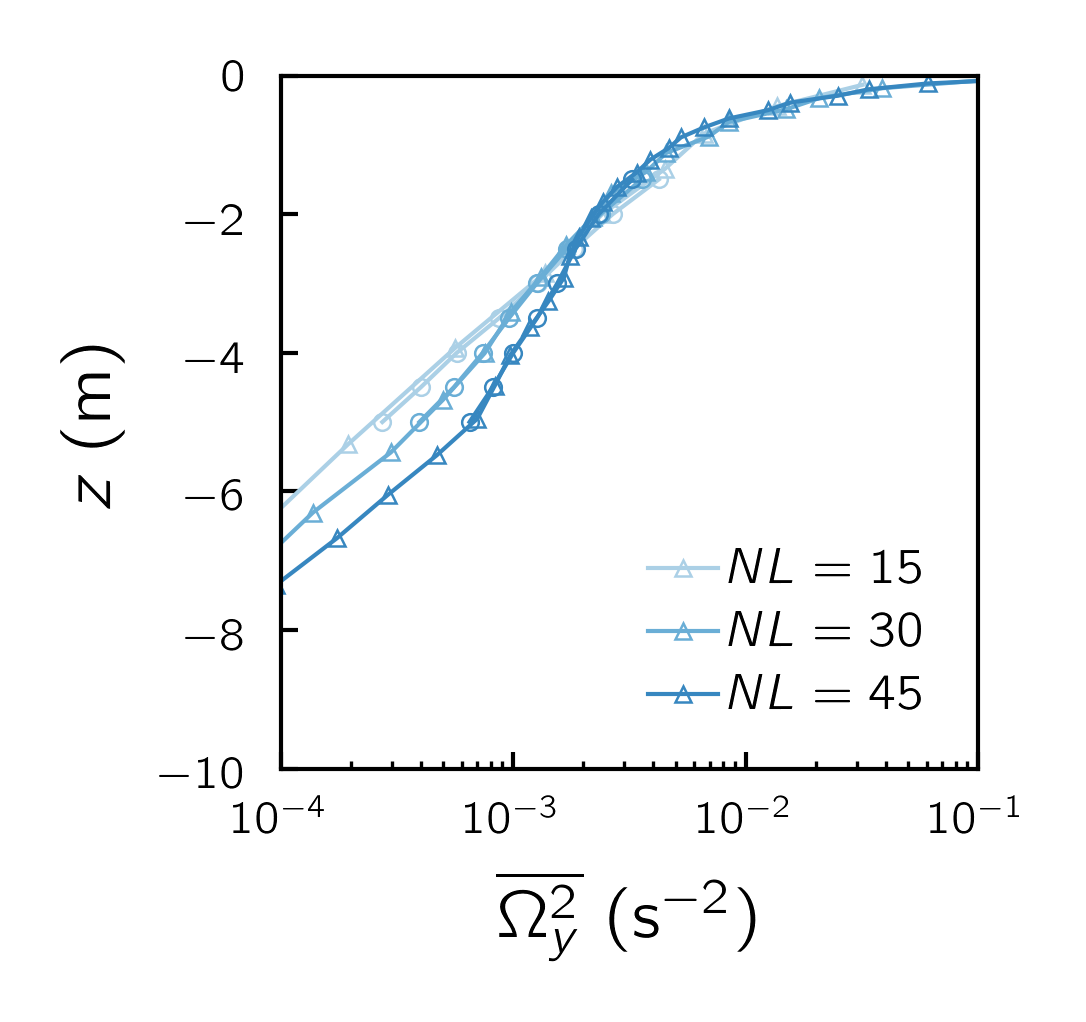

In [164]:
''' First square and then interpolate. '''
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

var_originals = []
var_interps = []
for i, ds in enumerate((ds1,ds2,ds3)):
    var = ds.omegay**2
    # layered coordinate
    var_originals.append(var.compute())
    # interpolate to absolute coordinate 
    var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
    var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{\Omega_y^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False, loc='lower right')
plt.show()

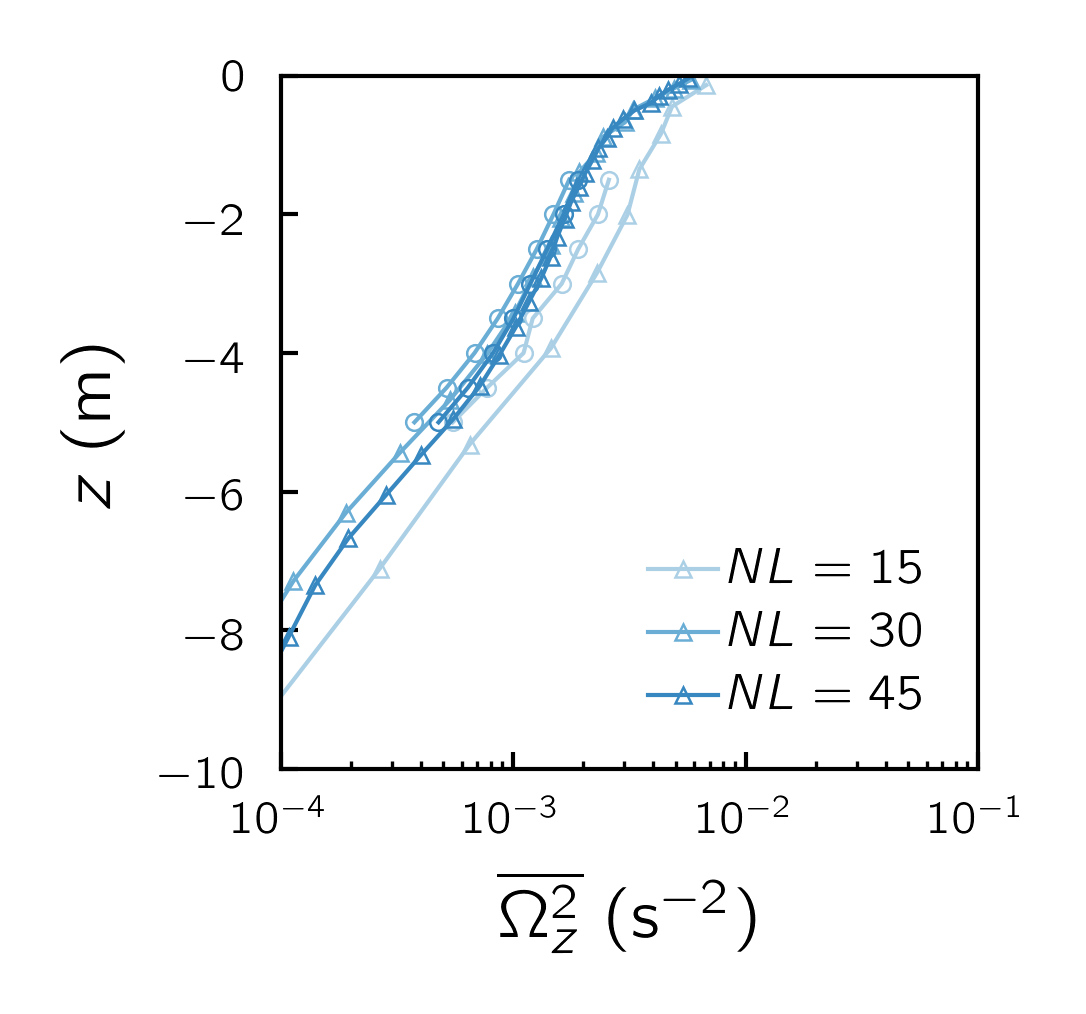

In [17]:
''' First interpolate and then square. '''

fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     var = ds.omegaz
#     # layered coordinate
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y'])
    omega2 = (var_originals[i].sel(t=t))**2
    ax.plot(omega2.mean(['x','y']), zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    omega2_interp = (var_interps[i])**2
    ax.plot(omega2_interp.mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{\Omega_z^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False, loc='lower right')
plt.show()

#### Vorticity magnitude squared

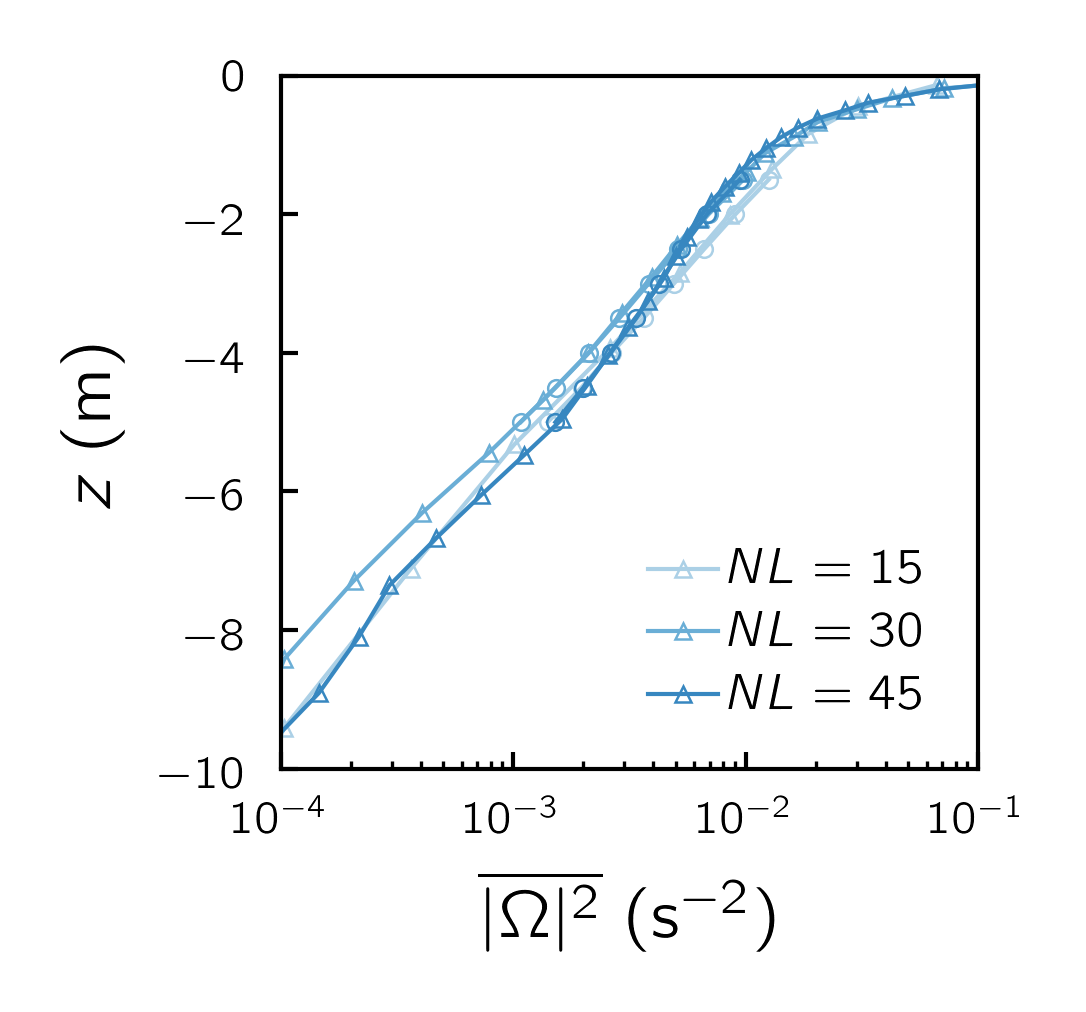

In [148]:
fig = plt.figure(figsize=[1.5,1.5]); ax = plt.gca()

t = 160
znew = np.arange(-5,-1.,0.5)

# var_originals = []
# var_interps = []
# for i, ds in enumerate((ds1,ds2,ds3)):
#     # layered coordinate
#     var = ds.omegax**2 + ds.omegay**2 + ds.omegaz**2
#     var_originals.append(var.compute())
#     # interpolate to absolute coordinate 
#     var_interp = interpz(znew, ds.z.sel(t=t), var.sel(t=t))
#     var_interps.append(var_interp.compute())

for i, ds in enumerate((ds1,ds2,ds3)):
    zmean = ds.z.sel(t=t).mean(['x','y']); mean = var_originals[i].sel(t=t).mean(['x','y'])
    ax.plot(mean, zmean, '-^', c=plt.get_cmap('Blues')((i+2)/6), label='$NL=%g$' %ds.sizes['zl'])
    ax.plot(var_interps[i].mean(['x','y']), znew, '-o', c=plt.get_cmap('Blues')((i+2)/6))
            
ax.set_ylim([-10,0])
ax.set_xlim([0.0001,0.1])
ax.set_xscale('log')
ax.set_xlabel(r'$\overline{|\mathbf{\Omega}|^2}\; \mathrm{(s^{-2})}$')
ax.set_ylabel(r'$z\; \mathrm{(m)}$')
ax.legend(fontsize=6, frameon=False)
plt.savefig('../figures/multilayer-diss/vort_new.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Playing with color cycles

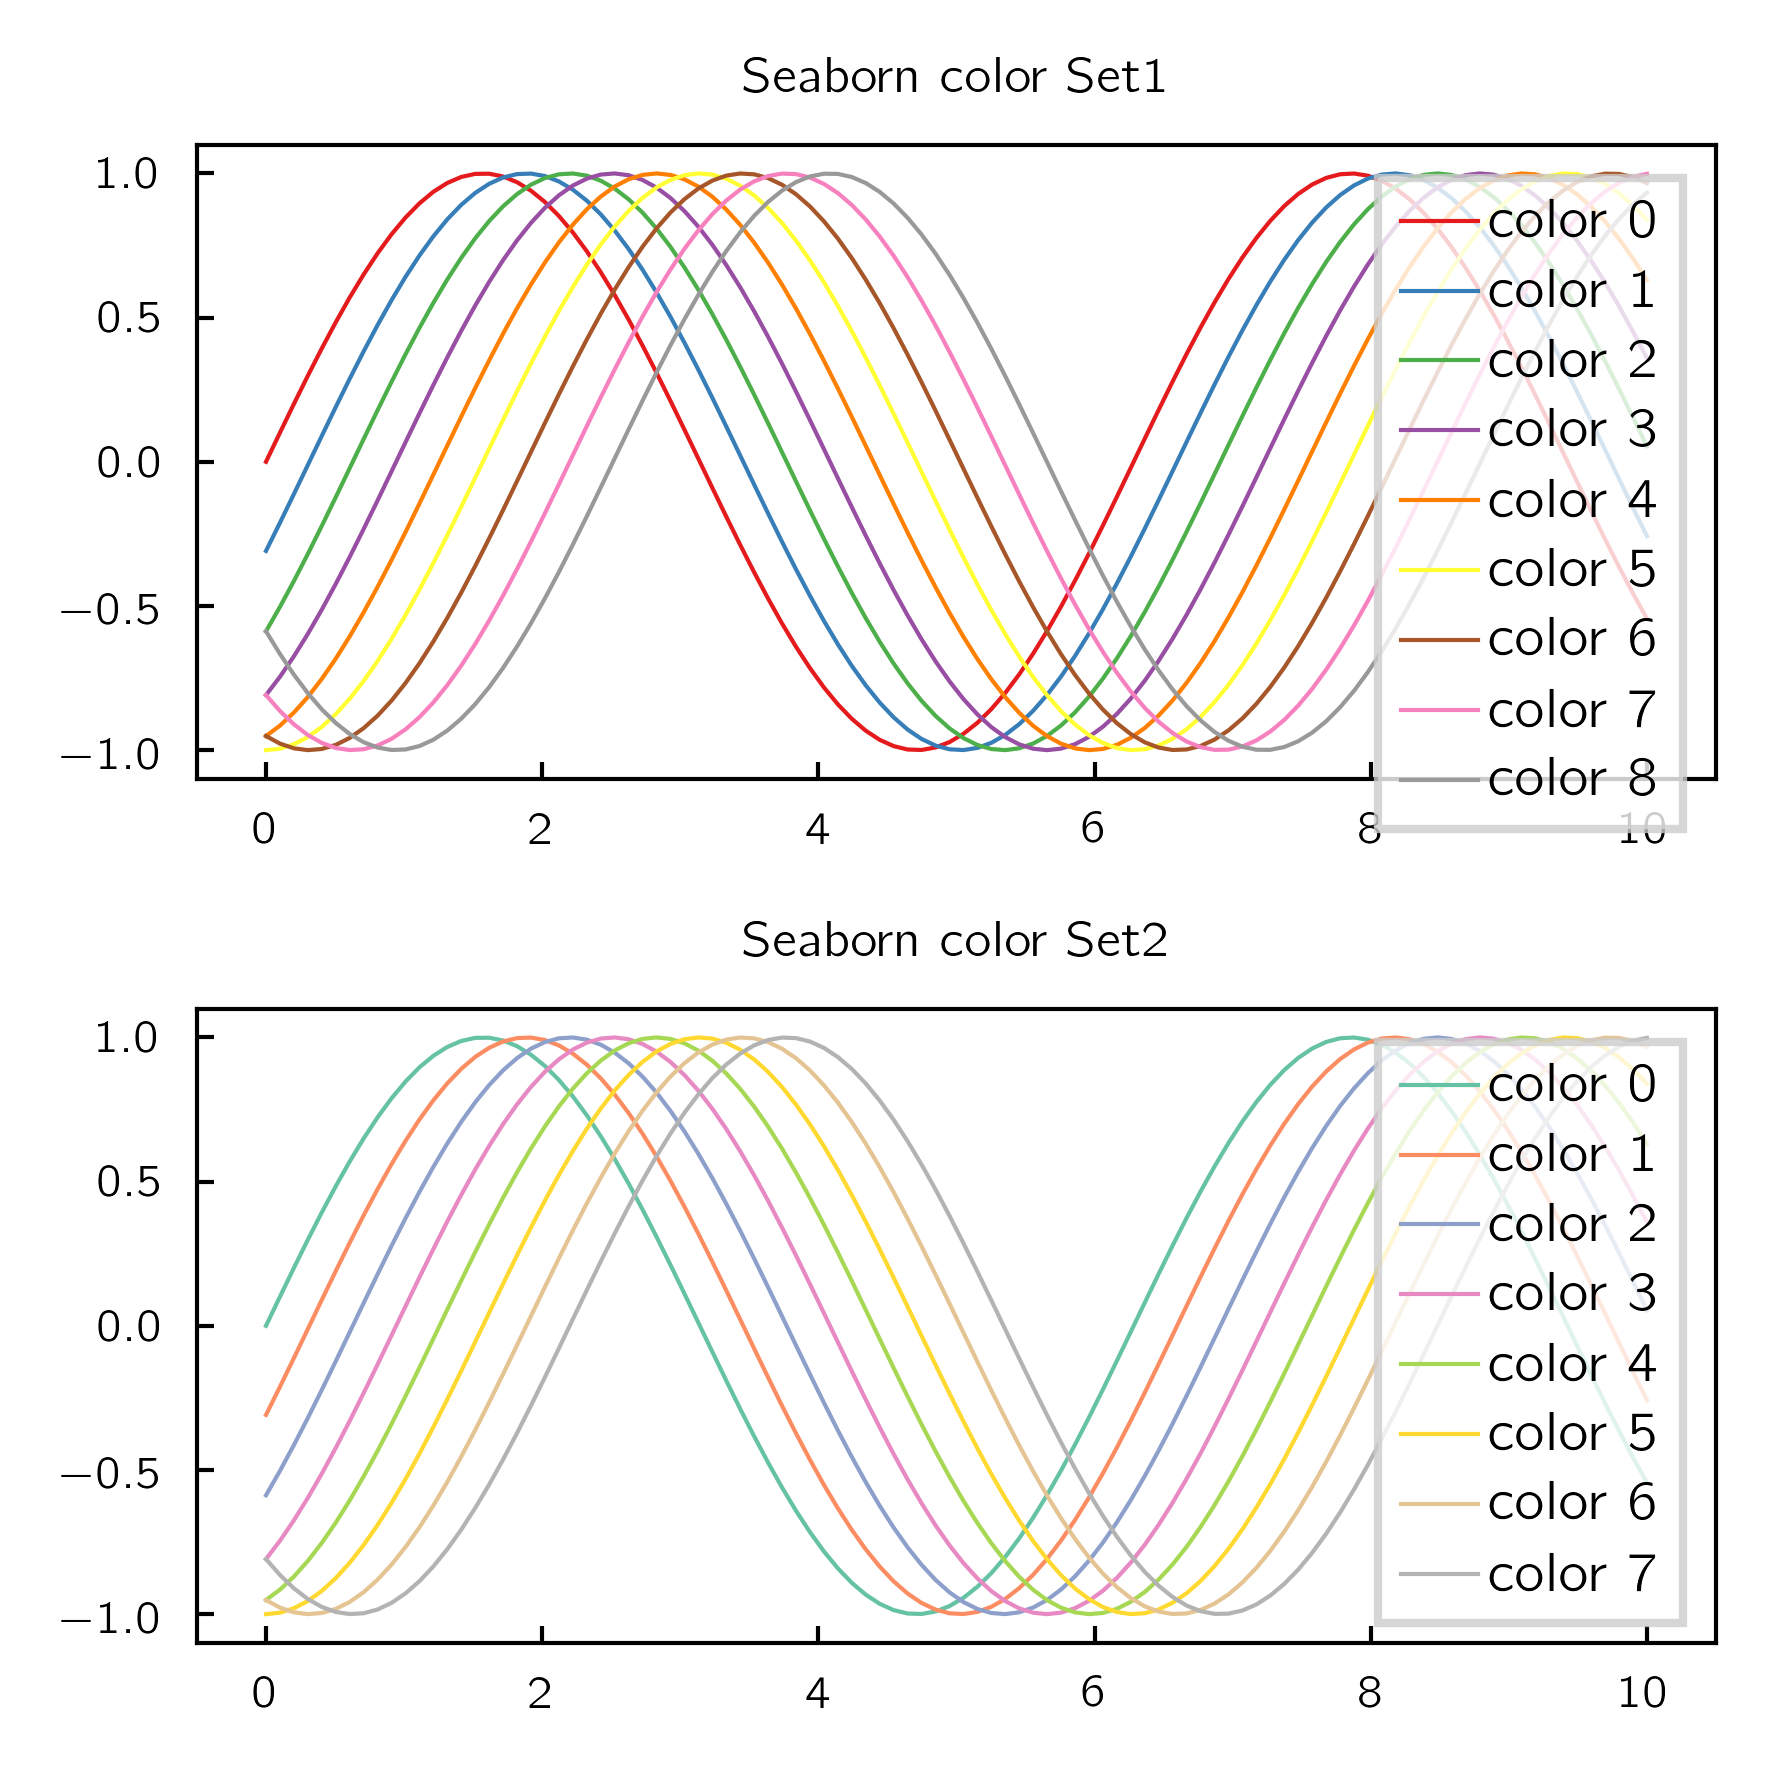

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cycler import cycler


# Choose a Seaborn color palette  
colornames = ['tab1','Set2']
fig, axes = plt.subplots(2, 1, figsize=[3,3])

for i, colorname in enumerate(colornames):
    
    axes[i].set_prop_cycle(cycler(color=sns_palette))

    for j in range(len(sns_palette)):
        # Create a plot using Matplotlib
        x = np.linspace(0, 10, 100)
        y = np.sin(x - np.pi / 10 * j)
        axes[i].plot(x, y, label='color %g' %j)
    
    axes[i].set_title('Seaborn color ' + colorname, fontsize=6)    
    axes[i].legend()
        
plt.tight_layout(); plt.show()

